In [2]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
###############################
# PRINT AVAILABLE REPORTS
###############################

reports_list = os.listdir()

def printList(x):
    print()
    for entry in x:
        print(entry)
        
reports_list = list(filter(lambda x: 'speed' in x or 'quality' in x, sorted(reports_list)))
print('***************************************')
print(f'Found {len(reports_list)} files in reports.')
print('***************************************')

speed_reports = list(filter(lambda x: 'speed' in x and not 'msdnet' in x, reports_list))
quality_reports = list(filter(lambda x: 'quality' in x and not 'msdnet' in x, reports_list))
print()
print(f'{len(speed_reports)} Speed reports vailable: ')
printList(speed_reports)
print()
print(f'{len(quality_reports)} Quality reports available:')
printList(quality_reports)

***************************************
Found 66 files in reports.
***************************************

30 Speed reports vailable: 

speed-densenet121-none-run.csv
speed-densenet121-skip-last-n-block-run.csv
speed-densenet121-skip-last-run.csv
speed-densenet121-skip-norm-n-run.csv
speed-densenet121-skip-run.csv
speed-densenet169-none-run.csv
speed-densenet169-skip-last-n-block-run.csv
speed-densenet169-skip-last-run.csv
speed-densenet169-skip-norm-n-run.csv
speed-densenet169-skip-run.csv
speed-resnet101-drop-last-rand-n-run.csv
speed-resnet101-drop-norm-n-run.csv
speed-resnet101-drop-rand-n-run.csv
speed-resnet101-none-run.csv
speed-resnet152-drop-last-rand-n-run.csv
speed-resnet152-drop-norm-n-run.csv
speed-resnet152-drop-rand-n-run.csv
speed-resnet152-none-run.csv
speed-resnet18-drop-last-rand-n-run.csv
speed-resnet18-drop-norm-n-run.csv
speed-resnet18-drop-rand-n-run.csv
speed-resnet18-none-run.csv
speed-resnet34-drop-last-rand-n-run.csv
speed-resnet34-drop-norm-n-run.csv
speed-

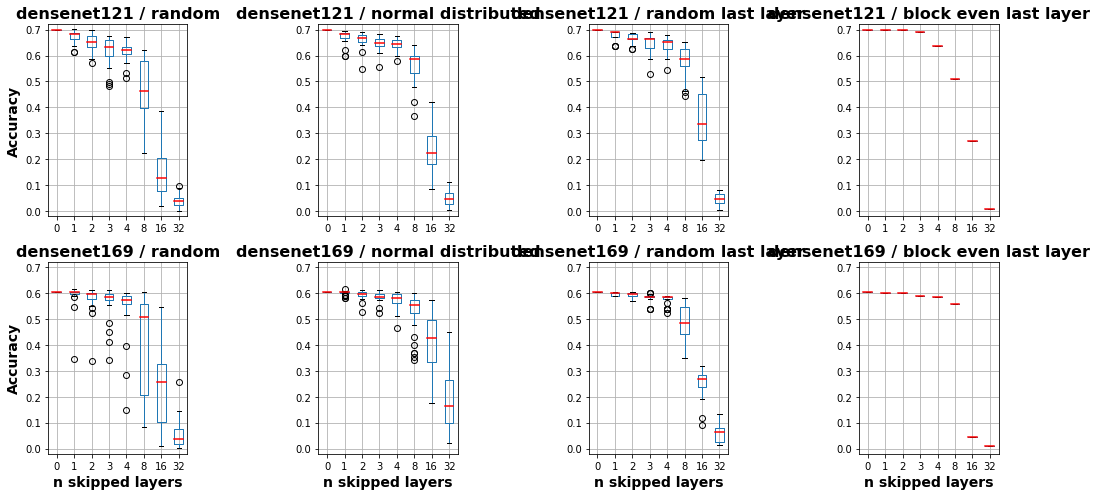

In [4]:
pol_trans = {
    'skip': 'random',
    'skip-last': 'random last layer',
    'skip-norm-n': 'normal distributed',
    'skip-last-n-block': 'block even last layer',
    'drop-rand-n': 'random',
    'drop-last-rand-n': 'last layer',
    'drop-norm-n': 'normal distributed'
}

def getDataFrameFromReports(csv_files):
    li = []
    for entry in csv_files:
        df = pd.read_csv(entry)
        if len(df) == 0:
            print("No data found in", entry)
        li.append(df)
    return pd.concat(li, axis=0, ignore_index=True)


s_df = getDataFrameFromReports(speed_reports)
q_df = getDataFrameFromReports(quality_reports)

base_q_df = q_df.query('pol == "none"')
#print(base_q_df)

#print(base_q_df[['arch', 'pol', 'prec', 'rec', 'acc', 'f1']])

#print(s_df.columns)
#print(q_df['arch'])

def printBoxPlotForArchAndPol(data_frame, arch_name, policy_name, ax, i=None, j=None, last_idx=None, limits=[-0.02, 0.72]):
    df, an, pn = data_frame, arch_name, policy_name

    df = df.query(f'arch == "{an}"')
    df = df.query(f'pol == "{pn}"')
    df = df.append(data_frame.query(f'arch == "{an}"').query(f'pol == "none"'))
    if len(df) == 0:
        print("No content found")
        return
    #print(df)
    bp = df.boxplot(
        column=['acc'], 
        by='skip_n', 
        figsize=(8, 6), 
        ax=ax,
        medianprops=dict(linestyle='-', linewidth=1.5, color='r')
        )
    fig = np.asarray(bp).reshape(-1)[0].get_figure()
    fig.suptitle('')
    if j is not None and j == 0:
    #if policy_name == 'skip' or policy_name == 'drop-rand-n':
        ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
    else:
        ax.set_ylabel('')

    if last_idx is not None and i is not None and i == last_idx:
        ax.set_xlabel('n skipped layers', fontsize=14, fontweight='bold')
    else:
        ax.set_xlabel('')
    ax.set_title(f'{an} / {pol_trans[pn]}', fontsize=16, fontweight='bold')
    if limits is not None:
        ax.set_ylim(limits)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))

from optparse import OptionParser
import inspect

#member_list = inspect.getmembers(axes[0, 0])
#for mem in member_list:
#    print(mem)

d_archs = ['densenet121', 'densenet169']
dense_pols = ['skip', 'skip-norm-n', 'skip-last', 'skip-last-n-block']

for i, arch in enumerate(d_archs):
    for j, pol in enumerate(dense_pols):
        printBoxPlotForArchAndPol(q_df, arch, pol, axes[i, j], i, j, last_idx=len(d_archs) - 1)
fig.tight_layout()
plt.show()


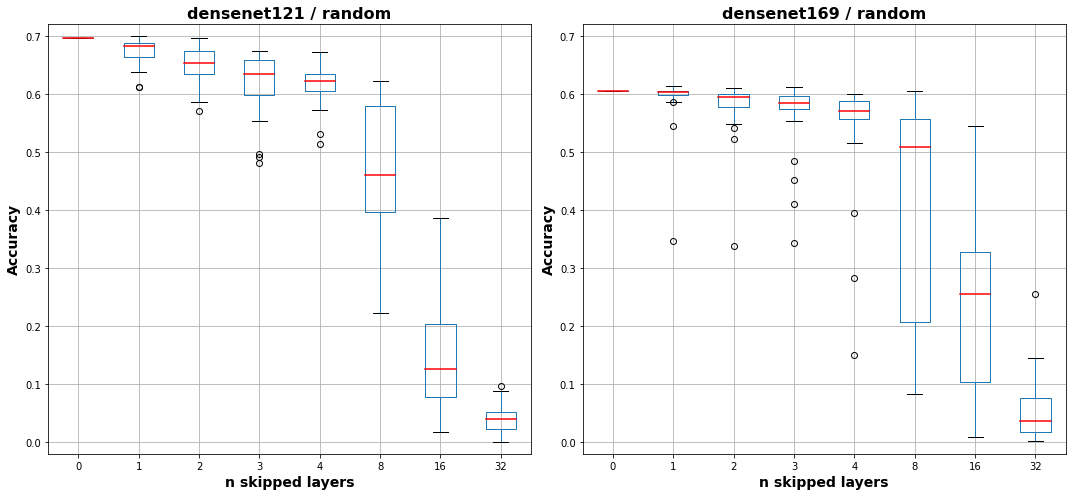

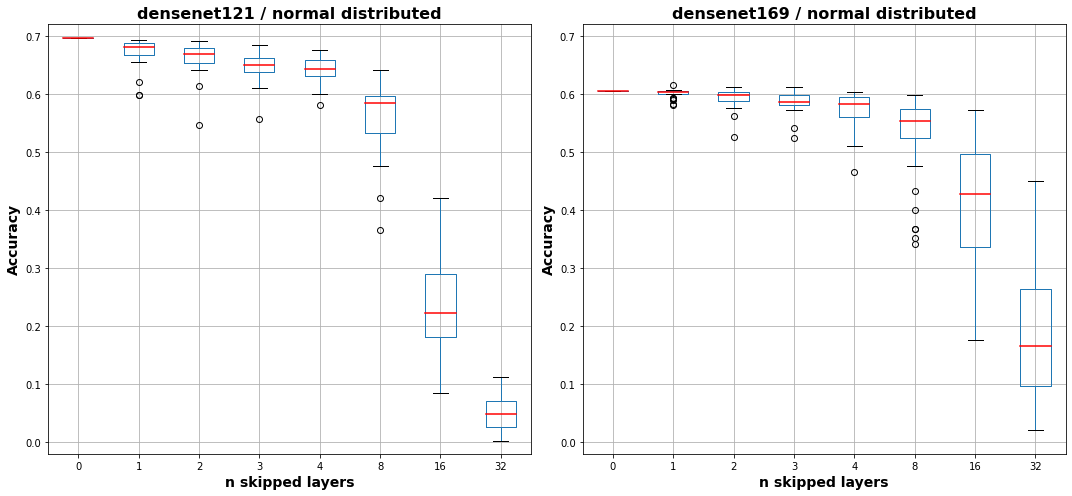

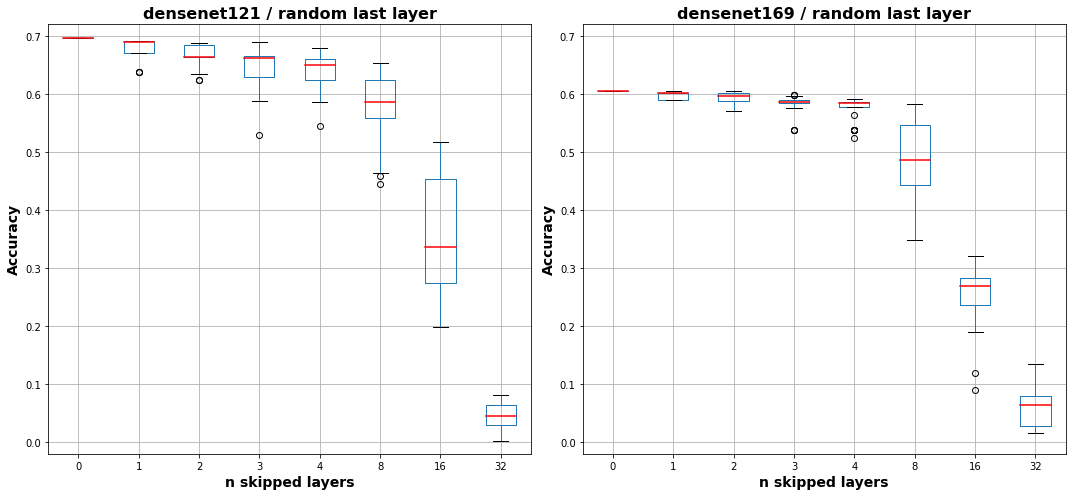

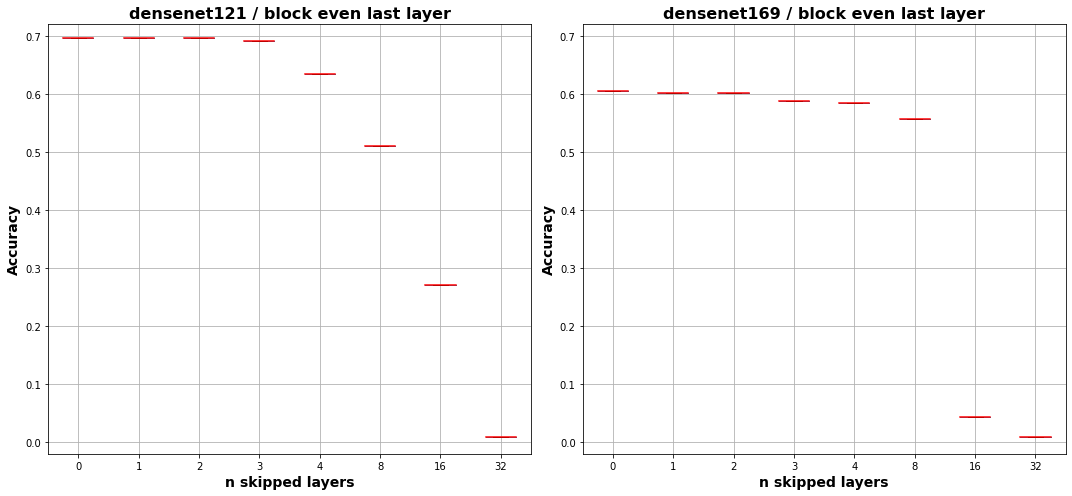

In [5]:
#######################################
# Print DenseNet-Quality Reports Policy 
# wise for all Variants.
#######################################


# Random Policy
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
for i, arch in enumerate(d_archs):
    printBoxPlotForArchAndPol(q_df, arch, dense_pols[0], axes[i], i=0, j=0, last_idx=0)
fig.tight_layout()
plt.show()

# Normal Distributed
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
for i, arch in enumerate(d_archs):
    printBoxPlotForArchAndPol(q_df, arch, dense_pols[1], axes[i], i=0, j=0, last_idx=0)
fig.tight_layout()
plt.show()

# Skip Random Last in Block
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
for i, arch in enumerate(d_archs):
    printBoxPlotForArchAndPol(q_df, arch, dense_pols[2], axes[i], i=0, j=0, last_idx=0)
fig.tight_layout()
plt.show()

# Skip Blockwise Last N
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
for i, arch in enumerate(d_archs):
    printBoxPlotForArchAndPol(q_df, arch, dense_pols[3], axes[i], i=0, j=0, last_idx=0)
fig.tight_layout()
plt.show()



In [6]:
q_df[q_df['pol'] == 'none']

,run,skip_n,bench_type,arch,pol,prec,rec,acc,f1,time
0,0,0,quality,densenet121,none,0.699469,0.699587,0.696574,0.696695,0.0
841,0,0,quality,densenet169,none,0.609158,0.609083,0.605195,0.598779,0.0
2312,0,0,quality,resnet101,none,0.704022,0.704482,0.696214,0.695561,0.0
2943,0,0,quality,resnet152,none,0.613205,0.613408,0.613036,0.597173,0.0
3394,0,0,quality,resnet18,none,0.697951,0.698698,0.695692,0.690065,0.0
3935,0,0,quality,resnet34,none,0.717683,0.718657,0.715894,0.709510,0.0
4476,0,0,quality,resnet50,none,0.646345,0.647278,0.644406,0.630677,0.0


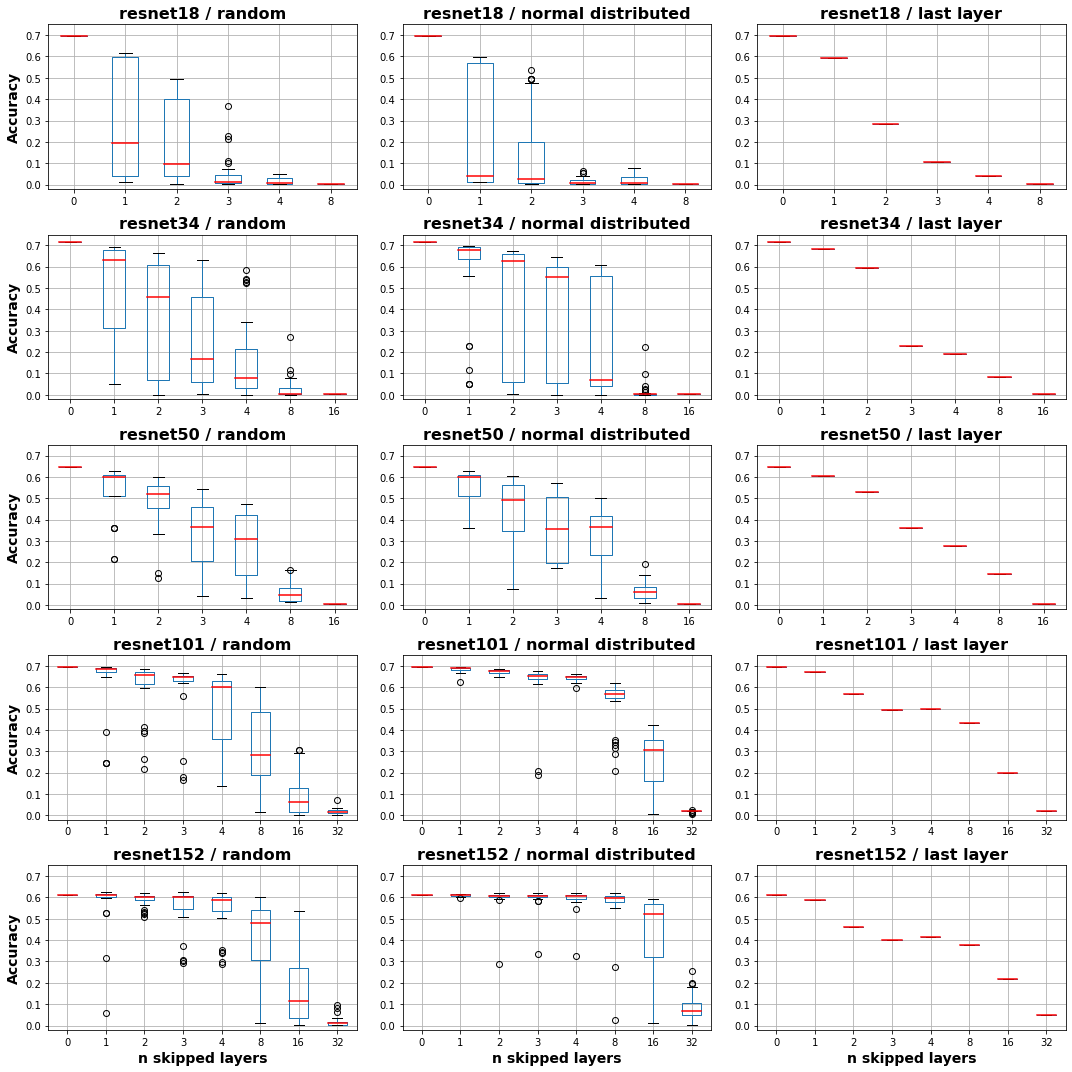

In [7]:
r_archs = ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']
r_pols = ['drop-rand-n', 'drop-norm-n', 'drop-last-rand-n']

fig, axes = plt.subplots(nrows=len(r_archs), ncols=3, figsize=(15, 3 * len(r_archs)))

for i, arch in enumerate(r_archs):
    for j, pol in enumerate(r_pols):
        printBoxPlotForArchAndPol(q_df, arch, pol, axes[i, j], i, j, last_idx=len(r_archs) - 1, limits=[-0.02, 0.75])

fig.tight_layout()
plt.show()

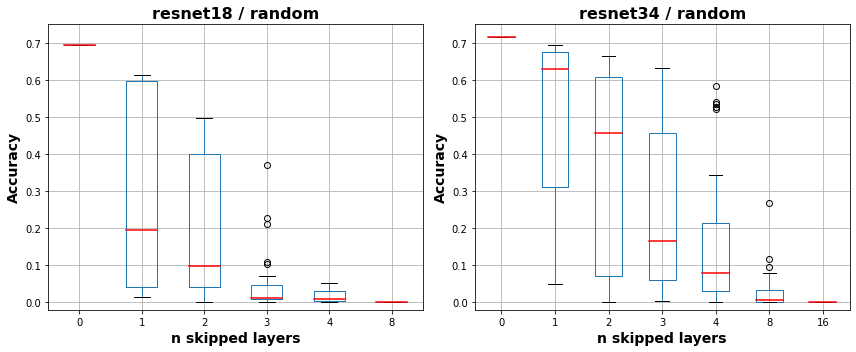

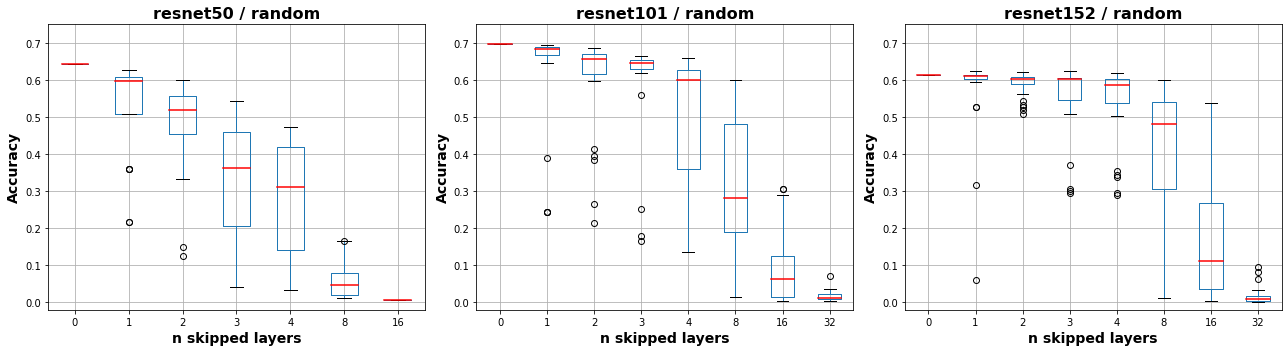

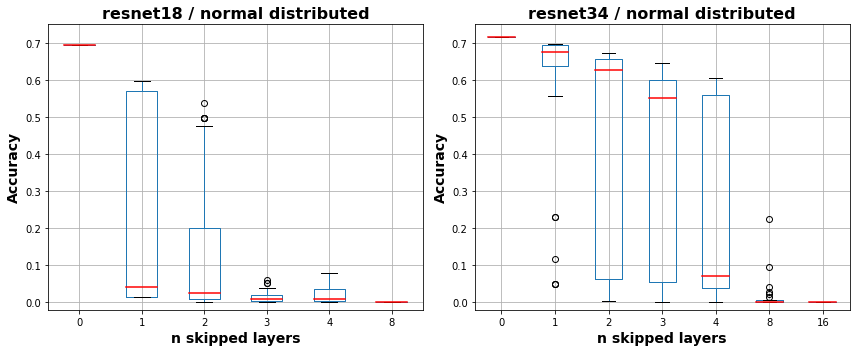

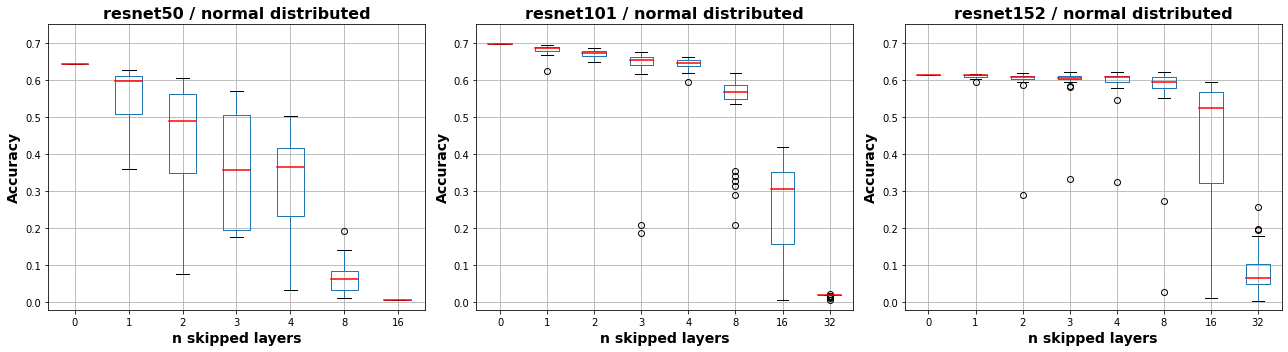

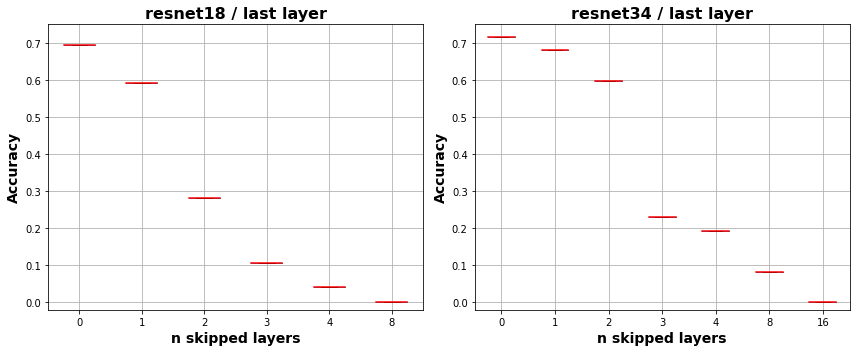

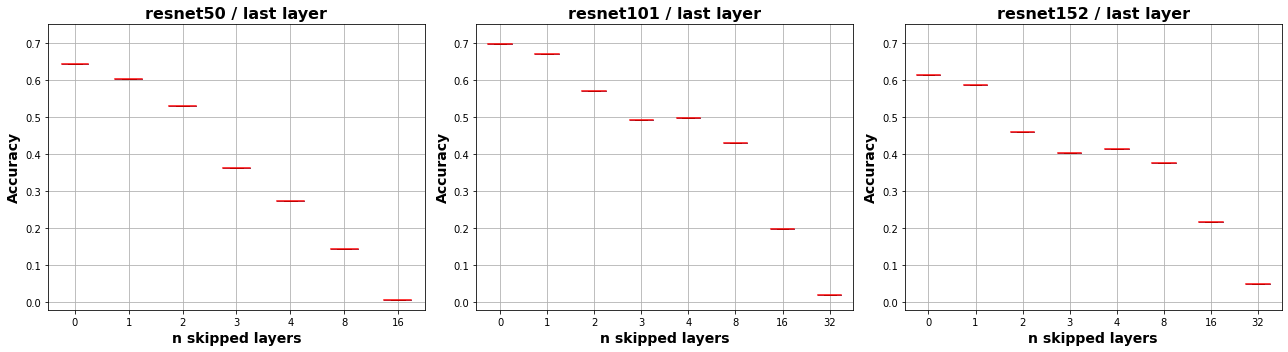

In [8]:

# Random
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
for i, arch in enumerate([r_archs[0], r_archs[1]]):
    printBoxPlotForArchAndPol(q_df, arch, r_pols[0], axes[i], i=0, j=0, last_idx=0, limits=[-0.02, 0.75])
fig.tight_layout()
plt.show()

fig2, axes2 = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
for i, arch in enumerate([r_archs[2], r_archs[3], r_archs[4]]):
    printBoxPlotForArchAndPol(q_df, arch, r_pols[0], axes2[i], i=0, j=0, last_idx=0, limits=[-0.02, 0.75])
fig2.tight_layout()
plt.show()

# Normal
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
for i, arch in enumerate([r_archs[0], r_archs[1]]):
    printBoxPlotForArchAndPol(q_df, arch, r_pols[1], axes[i], i=0, j=0, last_idx=0, limits=[-0.02, 0.75])
fig.tight_layout()
plt.show()

fig2, axes2 = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
for i, arch in enumerate([r_archs[2], r_archs[3], r_archs[4]]):
    printBoxPlotForArchAndPol(q_df, arch, r_pols[1], axes2[i], i=0, j=0, last_idx=0, limits=[-0.02, 0.75])
fig2.tight_layout()
plt.show()

# Last
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
for i, arch in enumerate([r_archs[0], r_archs[1]]):
    printBoxPlotForArchAndPol(q_df, arch, r_pols[2], axes[i], i=0, j=0, last_idx=0, limits=[-0.02, 0.75])
fig.tight_layout()
plt.show()

fig2, axes2 = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
for i, arch in enumerate([r_archs[2], r_archs[3], r_archs[4]]):
    printBoxPlotForArchAndPol(q_df, arch, r_pols[2], axes2[i], i=0, j=0, last_idx=0, limits=[-0.02, 0.75])
fig2.tight_layout()
plt.show()

In [7]:
temp_df = s_df.query('arch == "resnet50" and pol == "drop-rand-n"')

temp_df

temp_df = temp_df.groupby(['skip_n', 'arch', 'pol']).agg({'time': 'mean'})

temp_df

,,,time
skip_n,arch,pol,
1,resnet50,drop-rand-n,0.799793
2,resnet50,drop-rand-n,0.742037
3,resnet50,drop-rand-n,0.687575
4,resnet50,drop-rand-n,0.655965
8,resnet50,drop-rand-n,0.412202
16,resnet50,drop-rand-n,0.076524


In [17]:
#from scipy import stats
#print(s_df)
#s_df[['run', 'skip_n', 'arch', 'time']]

grouped_df = s_df.groupby(['skip_n', 'arch', 'pol']).agg({'time': [np.average]}).reset_index()
grouped_df

def getDataFrameWithoutOutliers(df):
    total_df = pd.DataFrame()
    
    for n in df['skip_n'].unique():
        for arch in df['arch'].unique():
            for pol in df['pol'].unique():
                if pol is not 'none':
                    temp_df = df[df['skip_n'] == n]
                    temp_df = temp_df[temp_df['arch'] == arch]
                    temp_df = temp_df[temp_df['pol'] == pol]
                
                    temp_df = temp_df[np.abs(temp_df.time-temp_df.time.mean()) <= (3 * temp_df.time.std())]
                    total_df = total_df.append(temp_df)
    return total_df

test2_df = getDataFrameWithoutOutliers(s_df).reset_index()
print(len(test2_df))
print(len(s_df))
grouped2_df = test2_df.groupby(['skip_n', 'arch', 'pol']).agg({'time': [np.average]}).reset_index()
grouped2_df = grouped2_df.append(grouped_df[grouped_df['pol'] == 'none']).reset_index()

print(len(grouped_df))

print(len(grouped2_df))

#grouped_df = grouped2_df
grouped_df = s_df.groupby(['skip_n', 'arch', 'pol']).agg({'time': 'mean'}).reset_index()
#grouped_df[grouped_df['arch'] == 'resnet50']

grouped_df = grouped_df.drop(grouped_df[(grouped_df.pol == 'none') & (grouped_df.skip_n > 1)].index)
#grouped_df[grouped_df['pol'] == 'none'].skip_n = 0
grouped_df.loc[(grouped_df.pol == 'none'), 'skip_n'] = 0



5088
5133
174
196


In [10]:
#########################################
# Generate Speed-Up Comparison table 
# for latex an ResNet and DenseNet 
# Architectures
#########################################

t = grouped_df[grouped_df['pol'] == 'none']

nt_map = dict()
for arch in t.arch.unique():
    time = t[t.arch == arch]
    time = time['time'].values[0]
    #print(f'{arch} - base time: {time}')
    nt_map.update({arch: round(time, 5)})
#print(nt_map)

t = grouped_df[grouped_df['pol'] == 'drop-rand-n'].append(grouped_df[grouped_df['pol'] == 'skip'])
#print(t)

for arch in t.arch.unique():
    txt = f'{arch.rjust(12)} [{str(round(nt_map[arch], 4)).rjust(5)}]'
    temp = t[t.arch == arch]
    base_time = nt_map[arch]
    for n in temp.skip_n.unique():
        time = temp[temp['skip_n'] == n]
        time = time['time'].values[0]
        txt += f' & {str(round(base_time / time, 2)).rjust(5)}'
    print(txt + ' \\\\')


   resnet101 [2.1877] &  1.04 &  1.12 &  1.11 &  1.17 &  1.57 &  2.28 & 12.77 \\
   resnet152 [2.3812] &  1.07 &   1.1 &  1.12 &  1.13 &  1.24 &  1.53 &   2.8 \\
    resnet18 [0.1857] &  1.11 &  1.26 &   1.5 &  1.76 & 13.16 \\
    resnet34 [0.3261] &  1.06 &  1.15 &  1.27 &  1.36 &  2.23 & 21.75 \\
    resnet50 [0.8339] &  1.04 &  1.12 &  1.21 &  1.27 &  2.02 &  10.9 \\
 densenet121 [0.0854] &  0.96 &  1.01 &  0.96 &  0.99 &  1.14 &  1.29 &  1.76 \\
 densenet169 [0.1371] &  1.21 &  1.23 &  1.29 &  1.25 &  1.37 &  1.49 &  1.73 \\


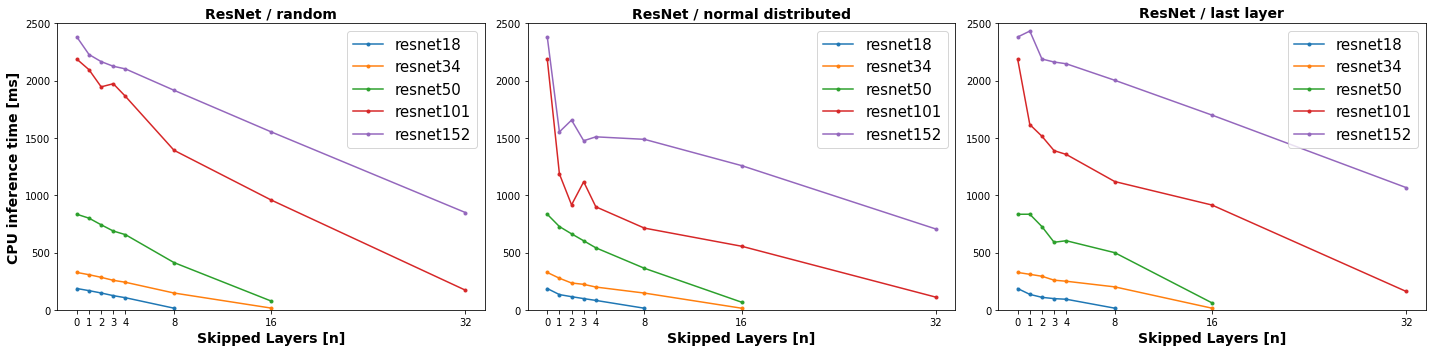

In [21]:
############################################
# GENERATE THE INFERENCE TIME LINE-CHART FOR 
# RESNET
############################################

#grouped_df['time'] = grouped_df['time'].multiply(1000)

tr_archs = r_archs

font = dict()
font['fontsize'] = 14
font['fontweight'] = 'bold'

def linePlotArchs(df, policy, archs, ax, max_y=None):
    if max_y is not None:
        ax.set_ylim([0.0, max_y])

    pol_df = df[df['pol'] == policy]

    arch_type = 'ResNet' if 'res' in archs[0] else 'DenseNet'

    ax.set_title(f'{arch_type} / {pol_trans[policy]}', font)
    for arch in archs:
        plot_df = pol_df[pol_df['arch'] == f'{arch}']
        plot_df = df[df['arch'] == arch][df['pol'] == "none"].append(plot_df)
        plot_df.time = plot_df.time.multiply(1000)
        ax.plot(plot_df.skip_n.to_numpy(), plot_df.time.to_numpy(),'.-', label=arch, axes=ax)
    ax.legend(fontsize=15)
    ax.set_xticks(plot_df['skip_n'])
    ax.set_xlabel('Skipped Layers [n]', font)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
axes[0].set_ylabel('CPU inference time [ms]', font)


for i, pol in enumerate(r_pols):
    linePlotArchs(grouped_df, pol, tr_archs, axes[i], 2500)

fig.tight_layout()
plt.show()

In [22]:
grouped_df[grouped_df['pol'] == 'none']

,skip_n,arch,pol,time
0,0.0,densenet121,none,0.085398
1,0.0,densenet169,none,0.137058
2,0.0,resnet101,none,2.187679
3,0.0,resnet152,none,2.381245
19,0.0,resnet18,none,0.185659
23,0.0,resnet34,none,0.326067
27,0.0,resnet50,none,0.833904


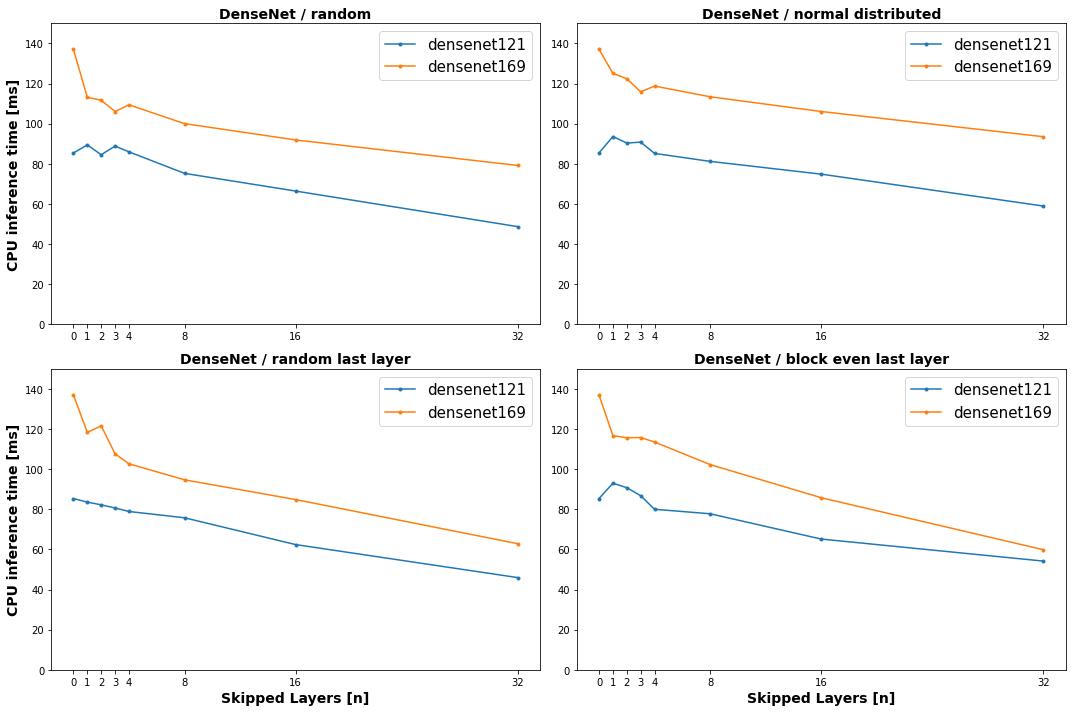

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes[0, 0].set_ylabel('CPU inference time [ms]', font)
axes[1, 0].set_ylabel('CPU inference time [ms]', font)
axes_ls = [axes[0, 0], axes[0, 1], axes[1,0], axes[1,1]]

for i, pol in enumerate(dense_pols):
    linePlotArchs(grouped_df, pol, d_archs, axes_ls[i], 150)

axes_ls[0].set_xlabel('')
axes_ls[1].set_xlabel('')

fig.tight_layout()
plt.show()

In [10]:
def executeQualityBench(arch_name, loader):
    prec = random.random()
    acc = random.random()
    rec = random.random()

    return prec, acc, rec

def executeSpeedBench(arch_name, loader):
    speed = random.random()
    return speed



d = {'run': [], 'skip_n': [], 'bench_type': [], 'arch': [], 'pol': [], 'prec': [], 'rec': [], 'acc': [], 'time': []}


loader = []

for bench_type in bench_types:
    for arch, pol in arch_pol_tupl_ls:
        for skip_n in skip_layers_values:
            for run in range(runs):
                prec = 0.0
                rec = 0.0
                acc = 0.0
                time = 0.0
                if bench_type == 'quality':
                    prec, acc, rec = executeQualityBench(f'{arch}-{pol}', loader)
                    #print(f'{run} - {skip_n} - {bench_type} - {arch} - {pol} - {prec:.6f} - {rec:.6f} - {acc:.6f}')
                elif bench_type == 'speed':
                    time = executeSpeedBench(f'{arch}-{pol}', loader)
                    #print(f'{run} - {skip_n} - {bench_type} - {arch} - {pol} - {time:.6f}')
                else:
                    raise ValueError('Benchmark type not supported')
                
                d['run'].append(run)
                d['skip_n'].append(skip_n)
                d['bench_type'].append(bench_type)
                d['arch'].append(arch)
                d['pol'].append(pol)
                d['prec'].append(prec)
                d['rec'].append(rec)
                d['acc'].append(acc)
                d['time'].append(time)

NameError: name 'bench_types' is not defined

In [22]:
df = pd.DataFrame(data=d)
reports_path = os.path.join(os.getcwd())
print(reports_path)
if not os.path.isdir:
    os.mkdir(reports_path)
df.to_csv(os.path.join(reports_path, 'run.csv'), index=False)
columns = list(d.keys())
print(columns)

/home/alex/Projects/Studium/anytimeDnn/reports
['run', 'skip_n', 'bench_type', 'arch', 'pol', 'prec', 'rec', 'acc', 'time']


In [3]:
####################################
# READING THE GENERATED REPORTS OF
# MSDNET ARCHITECTURES
####################################

def getDataFrameFromReports(csv_files):
    li = []
    for entry in csv_files:
        df = pd.read_csv(entry)
        if len(df) == 0:
            print("No data found in", entry)
        li.append(df)
    return pd.concat(li, axis=0, ignore_index=True)

msd_archs = ['msdnet4', 'msdnet5', 'msdnet10']
msd_pol = ['none']

reports_list = os.listdir()

reports_list = list(filter(lambda x: 'msdnet' in x, sorted(reports_list)))

reports_list

q_df = list(filter(lambda x: 'quality' in x, reports_list))
s_df = list(filter(lambda x: 'speed' in x, reports_list))

printList(q_df)
printList(s_df)

q_df = getDataFrameFromReports(q_df)
s_df = getDataFrameFromReports(s_df)

print(len(q_df))
print(q_df)
print(len(s_df))
print(s_df)


quality-msdnet10-run.csv
quality-msdnet4-run.csv
quality-msdnet5-run.csv

speed-msdnet10-none-run.csv
speed-msdnet4-none-run.csv
speed-msdnet5-none-run.csv
19
    classifier      arch       acc      prec       rec        f1
0            1  msdnet10  0.277258  0.276646  0.271165  0.248995
1            2  msdnet10  0.251961  0.251318  0.216018  0.211109
2            3  msdnet10  0.229446  0.229306  0.182797  0.181290
3            4  msdnet10  0.263344  0.262791  0.231802  0.227872
4            5  msdnet10  0.293701  0.293018  0.264358  0.263445
5            6  msdnet10  0.275234  0.274459  0.249931  0.243842
6            7  msdnet10  0.289400  0.288826  0.264501  0.258510
7            8  msdnet10  0.231723  0.231493  0.184583  0.181238
8            9  msdnet10  0.288895  0.287827  0.261233  0.254585
9           10  msdnet10  0.284341  0.283950  0.255723  0.249479
10           1   msdnet4  0.544397  0.544919  0.564720  0.539733
11           2   msdnet4  0.595244  0.595490  0.603733  0.58

In [4]:
grouped_sdf = s_df.groupby(['classifier', 'arch'], as_index=False).agg({'time': 'mean'})


print(grouped_sdf[grouped_sdf['arch'] == 'msdnet4'])
print(grouped_sdf[grouped_sdf['arch'] == 'msdnet5'])
print(grouped_sdf[grouped_sdf['arch'] == 'msdnet10'])

    classifier     arch       time
1            1  msdnet4  33.527226
4            2  msdnet4  58.975202
7            3  msdnet4  76.980118
10           4  msdnet4  85.194645
    classifier     arch        time
2            1  msdnet5   31.248975
5            2  msdnet5   57.899610
8            3  msdnet5   78.043686
11           4  msdnet5   94.528414
13           5  msdnet5  101.213596
    classifier      arch        time
0            1  msdnet10   94.673660
3            2  msdnet10  183.502490
6            3  msdnet10  268.788230
9            4  msdnet10  322.321019
12           5  msdnet10  379.077001
14           6  msdnet10  435.216904
15           7  msdnet10  476.184633
16           8  msdnet10  509.202994
17           9  msdnet10  530.303623
18          10  msdnet10  552.601962


   classifier      arch      time
0           1  msdnet10  94.67366
4
5
10


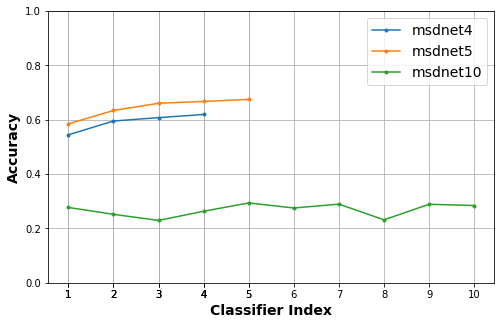

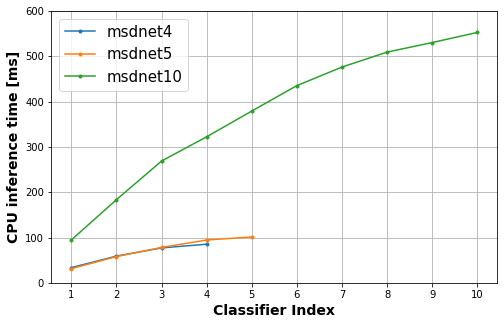

In [5]:

font = dict()
font['fontsize'] = 14
font['fontweight'] = 'bold'
grouped_qdf = q_df.groupby(['classifier', 'arch'], as_index=False).agg({'acc': 'mean', 'prec': 'mean', 'rec': 'mean', 'f1': 'mean'})
grouped_qdf = grouped_qdf[['classifier', 'arch', 'acc']]

fix, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
axes.set_ylabel('Accuracy', font)
axes.set_ylim([0.0, 1.0])
axes.set_xticks(grouped_qdf['classifier'])
axes.set_xlabel('Classifier Index', font)

def plotMSDNet(axes, df, name: str):
    axes.grid(zorder=0)
    plot_df = df[df['arch'] == name]
    axes.plot(plot_df.classifier, plot_df.acc, '.-', label=name)


for arch in msd_archs:
    plotMSDNet(axes, grouped_qdf, arch)

axes.legend(fontsize=font['fontsize'])

print(grouped_sdf.head(1))

def linePlotArchsMSD(df, archs, ax, max_y=None):
    if max_y is not None:
        ax.set_ylim([0.0, max_y])
    ax.grid(zorder=0)
    for arch in archs:
        plot_df = df[df['arch'] == f'{arch}']
        print(len(plot_df))
        ax.plot(plot_df.classifier, plot_df.time,'.-', label=arch, axes=ax)
    ax.legend(fontsize=15)
    ax.set_xticks(plot_df['classifier'])
    ax.set_xlabel('Classifier Index', font)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
axes.set_ylabel('CPU inference time [ms]', font)

linePlotArchsMSD(grouped_sdf, ['msdnet4', 'msdnet5', 'msdnet10'], axes, max_y=600)